In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [25]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [6]:
lgb = pd.read_csv(r'../predictions/lgb_predictions.csv')
lgb.shape

(16523, 8)

In [7]:
lstm = pd.read_csv(r'../predictions/rnn_predictions.csv')
lstm.shape

(16100, 14)

In [8]:
lstm = pd.merge(lstm, lgb[['filename', 'trip_number', 'latitude_lgb_predicted', 'longitude_lgb_predicted']], on=['filename', 'trip_number'], how='inner')

# RMSE

In [19]:
print('Latitude: RMSE LSTM {0:0.3f}, RMSE LGB {1:0.3f}'.format(mean_squared_error(lstm.latitude_true, lstm.latitude_rnn_predicted), 
                                                      mean_squared_error(lstm.latitude_true, lstm.latitude_lgb_predicted)))

Latitude: RMSE LSTM 0.004, RMSE LGB 0.002


In [21]:
print('Longitude: RMSE LSTM {0:0.4f}, RMSE LGB {1:0.4f}'.format(mean_squared_error(lstm.longitude_true, lstm.longitude_rnn_predicted), 
                                                      mean_squared_error(lstm.longitude_true, lstm.longitude_lgb_predicted)))

Longitude: RMSE LSTM 0.0009, RMSE LGB 0.0006


# Kilometers between predicted and actual pickup locations

In [26]:
lstm['rnn_haversine_error'] = \
    haversine(lstm.latitude_rnn_predicted, lstm.longitude_rnn_predicted,
              lstm.latitude_true, lstm.longitude_true)

In [27]:
lstm['lgb_haversine_error'] = \
    haversine(lstm.latitude_lgb_predicted, lstm.longitude_lgb_predicted,
              lstm.latitude_true, lstm.longitude_true)

In [28]:
lstm['rnn_haversine_error'].mean(), lstm['lgb_haversine_error'].mean()

(5.057703493103932, 4.042947215545546)

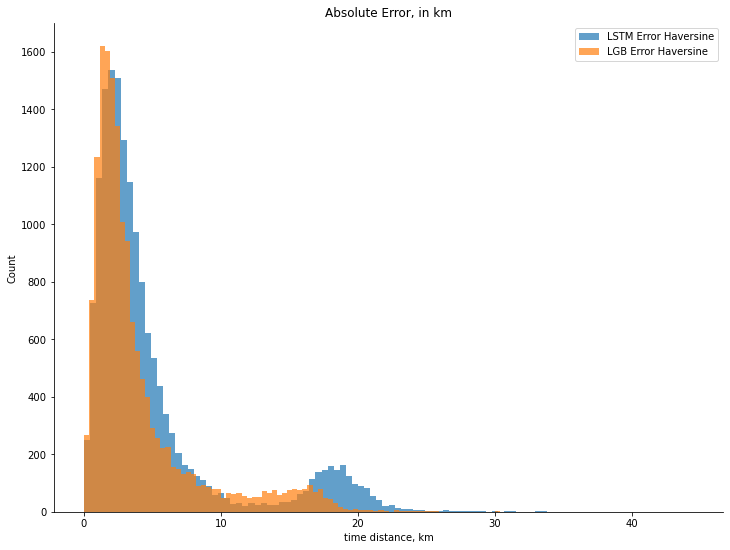

In [31]:
plt.figure(figsize=(12, 9))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xlabel("time distance, km")  
plt.ylabel("Count")  

plt.hist(lstm['rnn_haversine_error'], 
         bins=100, label = 'LSTM Error Haversine', alpha=0.7)  
plt.hist(lstm['lgb_haversine_error'], 
         bins=100, label = 'LGB Error Haversine', alpha=0.7)  
plt.title('Absolute Error, in km')
plt.legend()
plt.show()